
このノートブックを実行するには、次の追加ライブラリが必要です。 Colab での実行は実験的なものであることに注意してください。問題がある場合は、Github の問題を報告してください。


In [ ]:
!pip install d2l==1.0.0-beta0



# 線形回帰

:label: `sec_linear_regression`

数値を予測したいときはいつでも、*回帰*問題が発生します。一般的な例としては、価格の予測 (住宅、株式など)、入院期間の予測 (入院患者の場合)、需要の予測 (小売売上高) などが挙げられます。すべての予測問題が古典的な回帰問題であるわけではありません。後で、分類問題を紹介します。この問題の目的は、一連のカテゴリ内のメンバーシップを予測することです。

実行例として、面積 (平方フィート) と築年数 (年) に基づいて住宅の価格 (ドル) を推定したいとします。住宅価格を予測するモデルを開発するには、各住宅の販売価格、面積、築年数などの販売データを入手する必要があります。機械学習の用語では、データセットは*トレーニング データセット*または*トレーニング セット*と呼ばれ、各行 (1 つの販売に対応するデータを含む) は*サンプル*(または*データ ポイント*、*インスタンス*、*サンプル*) と呼ばれます。私たちが予測しようとしているもの (価格) は、*ラベル*(または*ターゲット*) と呼ばれます。予測の基礎となる変数 (年齢と面積) は、*特徴*(または*共変量*) と呼ばれます。


In [1]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l


## 基本

*線形回帰は、*回帰問題に取り組むための標準ツールの中で最も単純であり、最も普及している可能性があります。 19 世紀初頭まで遡ります :cite: `Legendre.1805,Gauss.1809` 、線形回帰はいくつかの単純な仮定に基づいて行われます。まず、特徴 $\mathbf{x}$ とターゲット $y$ の間の関係はほぼ線形であると仮定します。つまり、条件付き平均 $E[Y \mid X=\mathbf{x}]$ は次のように表すことができます。特徴 $\mathbf{x}$ の加重合計。この設定では、観測ノイズにより目標値が期待値から依然として逸脱する可能性があります。次に、そのようなノイズはガウス分布に従って正常に動作するという仮定を課すことができます。通常、データセット内の例の数を示すために $n$ を使用します。サンプルとターゲットを列挙するには上付き文字を使用し、座標のインデックスには下付き文字を使用します。より具体的には、$\mathbf{x}^{(i)}$ は $i$ 番目のサンプルを示し、$x_j^{(i)}$ はその $j$ 番目の座標を示します。

### モデル

:label: `subsec_linear_model`

すべてのソリューションの中心となるのは、特徴をターゲットの推定値に変換する方法を説明するモデルです。線形性の仮定は、ターゲットの期待値 (価格) が特徴 (面積と年齢) の加重和として表現できることを意味します。

 $$\mathrm{価格} = w_{\mathrm{面積}} \cdot \mathrm{面積} + w_{\mathrm{年齢}} \cdot \mathrm{年齢} + b.$$ :eqlabel: `eq_price-area`

ここで、 $w_{\mathrm{area}}$ と $w_{\mathrm{age}}$ は*重み*と呼ばれ、 $b$ は*バイアス*(または*オフセット*または*切片*) と呼ばれます。重みによって、予測に対する各特徴の影響が決まります。バイアスは、すべての特徴がゼロの場合の推定値を決定します。面積が正確にゼロの新築住宅は決して見られないとしても、バイアスが必要なのは、フィーチャのすべての線形関数を表現できるためです (原点を通過する線に制限するのではなく)。厳密に言えば、:eqref: `eq_price-area`入力特徴の*アフィン変換*であり、加重和による特徴の*線形変換*と、追加されたバイアスによる*変換*を組み合わせることを特徴とします。データセットが与えられた場合、私たちの目標は、平均してモデルの予測がデータ内で観測された真の価格にできるだけ近く適合する重み $\mathbf{w}$ とバイアス $b$ を選択することです。

ほんの数個の特徴を持つデータセットに焦点を当てることが一般的な分野では、 :eqref: `eq_price-area`のように、長い形式のモデルを明示的に表現することが一般的です。機械学習では通常、高次元のデータセットを扱いますが、その場合はコンパクトな線形代数表記を使用する方が便利です。入力が $d$ 特徴で構成されている場合、それぞれにインデックス ($1$ と $d$ の間) を割り当て、予測 $\hat{y}$ (一般に「ハット」記号は推定値を示します) を次のように表すことができます。

 $$\hat{y} = w_1 x_1 + ... + w_d x_d + b.$$

すべての特徴をベクトル $\mathbf{x} \in \mathbb{R}^d$ に集め、すべての重みをベクトル $\mathbf{w} \in \mathbb{R}^d$ に集めて、モデルを表現できます。 $\mathbf{w}$ と $\mathbf{x}$ の間のドット積を介してコンパクトに記述します。

 $$\hat{y} = \mathbf{w}^\top \mathbf{x} + b.$$ :eqlabel: `eq_linreg-y`

 :eqref: `eq_linreg-y`では、ベクトル $\mathbf{x}$ が 1 つの例の特徴に対応します。多くの場合、*計画行列*$\mathbf{X} \in \mathbb{R}^{n \times d}$ を介して $n$ 例のデータセット全体の特徴を参照すると便利です。ここで、$\mathbf{X}$ には、例ごとに 1 行、特徴ごとに 1 列が含まれています。特徴 $\mathbf{X}$ のコレクションの場合、予測 $\hat{\mathbf{y}} \in \mathbb{R}^n$ は行列とベクトルの積で表すことができます。

 $${\hat{\mathbf{y}}} = \mathbf{X} \mathbf{w} + b,$$ :eqlabel: `eq_linreg-y-vec`

ここで、ブロードキャスト (:numref: `subsec_broadcasting` ) は合計中に適用されます。トレーニング データセット $\mathbf{X}$ と対応する (既知の) ラベル $\mathbf{y}$ の特徴が与えられた場合、線形回帰の目標は重みベクトル $\mathbf{w}$ とバイアス項 $ を見つけることです。 $\mathbf{X}$ と同じ分布からサンプリングされた新しいデータ例の特徴が与えられると、新しい例のラベルは (予想通り) 最小の誤差で予測されます。

 $\mathbf{x}$ が与えられた場合、$y$ を予測するための最良のモデルは線形であると信じているとしても、$y^{(i)}$ である $n$ の例の現実世界のデータセットが見つかるとは期待できません。すべての $1 \leq i \leq n$ に対して $\mathbf{w}^\top \mathbf{x}^{(i)}+b$ と正確に等しくなります。たとえば、特徴 $\mathbf{X}$ とラベル $\mathbf{y}$ を観察するために使用する計測器はどれも、少量の測定誤差を被る可能性があります。したがって、基礎となる関係が線形であると確信している場合でも、そのような誤差を考慮してノイズ項を組み込みます。

最適な*パラメーター*(または*モデル パラメーター*) $\mathbf{w}$ と $b$ を検索する前に、さらに 2 つのことが必要になります。(i) 特定のモデルの品質尺度。 (ii) モデルを更新して品質を向上させる手順。

### 損失関数

:label: `subsec_linear-regression-loss-function`

当然のことながら、モデルをデータに適合させるには、ある程度の*適合性*(または同等の*非適合性*) の尺度に同意する必要があります。*損失関数は、*ターゲットの*実際の*値と*予測*値の間の距離を定量化します。通常、損失は非負の数値であり、値が小さいほど優れており、完全な予測では損失が 0 になります。回帰問題の場合、最も一般的な損失関数は二乗誤差です。例 $i$ の予測が $\hat{y}^{(i)}$ で、対応する真のラベルが $y^{(i)}$ である場合、*二乗誤差は次の*式で求められます。

 $$l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\右)^2.$$ :eqlabel: `eq_mse`

定数 $\frac{1}{2}$ は実質的な違いはありませんが、損失の導関数を計算すると相殺されるため、表記上は便利であることがわかります。トレーニング データセットは私たちに与えられており、私たちが制御できないため、経験的誤差はモデル パラメーターの関数にすぎません。以下では、1 次元入力 (:numref: `fig_fit_linreg` ) を使用した問題における線形回帰モデルの適合を視覚化します。 

![](../img/fit-linreg.svg) :label: `fig_fit_linreg`

推定 $\hat{y}^{(i)}$ と目標 $y^{(i)}$ の間に大きな差があると、損失の二次形式により、損失への寄与がさらに大きくなることに注意してください (これは、これはモデルが大きなエラーを回避することを促す一方で、異常なデータに対する過剰な敏感さにもつながる可能性があります)。 $n$ 個のサンプルのデータセット全体でモデルの品質を測定するには、トレーニング セットの損失を単純に平均 (または同等に合計) します。

 $$L(\mathbf{w}, b) =\frac{1}{n}\sum_{i=1}^nl^{(i)}(\mathbf{w}, b) =\frac{1 }{n} \sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{( i)}\right)^2.$$

モデルをトレーニングするときは、すべてのトレーニング例にわたる総損失を最小限に抑えるパラメーター ($\mathbf{w}^ *, b^* $) を見つけたいと考えます。

 $$\mathbf{w}^ *, b^* = \operatorname*{argmin}_{\mathbf{w}, b}\ L(\mathbf{w}, b).$$

### 分析ソリューション

これから説明するほとんどのモデルとは異なり、線形回帰は驚くほど簡単な最適化問題を提示します。特に、次のような簡単な式を適用することで、(トレーニング データで評価された) 最適なパラメーターを分析的に見つけることができます。まず、すべて 1 で構成される計画行列に列を追加することで、バイアス $b$ をパラメーター $\mathbf{w}$ に含めることができます。したがって、予測の問題は $|\mathbf{y} - \mathbf{X}\mathbf{w}|^2$ を最小化することです。計画行列 $\mathbf{X}$ がフルランクである限り (どの特徴も他の特徴に線形依存しない)、損失曲面上には臨界点が 1 つだけ存在し、それは次の範囲にわたる損失の最小値に対応します。ドメイン全体。 $\mathbf{w}$ に関して損失の導関数を取得し、それをゼロに設定すると、次の結果が得られます。

 $$\begin{aligned} \partial_{\mathbf{w}} |\mathbf{y} - \mathbf{X}\mathbf{w}|^2 = 2 \mathbf{X}^\top (\mathbf{ X} \mathbf{w} - \mathbf{y}) = 0 \text{ したがって、 } \mathbf{X}^\top \mathbf{y} = \mathbf{X}^\top \mathbf{X} \ mathbf{w}。 \end{整列}$$

 $\mathbf{w}$ を解くと、最適化問題の最適解が得られます。この解決策は、

 $$\mathbf{w}^* = (\mathbf X^\top \mathbf X)^{-1}\mathbf X^\top \mathbf{y}$$

行列 $\mathbf X^\top \mathbf X$ が可逆である場合、つまり計画行列の列が線形独立している場合にのみ一意になります (引用: `Golub.Van-Loan.1996` )。

線形回帰のような単純な問題では分析による解決が可能かもしれませんが、そのような幸運に慣れるべきではありません。分析ソリューションは優れた数学的分析を可能にしますが、分析ソリューションの要件は非常に限定的であるため、深層学習のほとんどすべての興味深い側面が排除されてしまいます。

### ミニバッチ確率的勾配降下法

幸いなことに、モデルを分析的に解決できない場合でも、実際にはモデルを効果的にトレーニングできることがよくあります。さらに、多くのタスクでは、最適化が難しいモデルのほうがはるかに優れていることが判明し、モデルをトレーニングする方法を見つけることは、苦労する価値があります。

ほぼすべてのディープ ラーニング モデルを最適化するための重要なテクニックは、本書全体で取り上げますが、損失関数を段階的に下げる方向にパラメーターを更新することで誤差を反復的に減らすことで構成されます。このアルゴリズムは*勾配降下法*と呼ばれます。

勾配降下法の最も素朴な応用は、データセット内のすべての単一の例で計算された損失の平均である損失関数の導関数を取得することで構成されます。実際には、これは非常に遅くなる可能性があります。たとえ更新手順が非常に強力であっても、単一の更新を行う前にデータセット全体を渡す必要があります (引用: `Liu.Nocedal.1989` )。さらに悪いことに、トレーニング データに多くの冗長性がある場合、完全な更新のメリットはさらに低くなります。

もう 1 つの極端な方法は、一度に 1 つの例だけを考慮し、一度に 1 つの観察に基づいて更新手順を実行することです。結果として得られるアルゴリズムである*確率的勾配降下法*(SGD) は、大規模なデータセットであっても効果的な戦略となり得ます :cite: `Bottou.2010` 。残念ながら、SGD には計算と統計の両方で欠点があります。 1 つの問題は、プロセッサがメイン メモリからプロセッサ キャッシュにデータを移動するときよりも、数値の乗算と加算の方がはるかに高速であるという事実から発生します。行列とベクトルの乗算を実行する方が、対応する数のベクトルとベクトルの演算を実行するよりも最大 1 桁効率的です。これは、完全なバッチと比較して、一度に 1 つのサンプルを処理する方がはるかに長い時間がかかる可能性があることを意味します。 2 番目の問題は、バッチ正規化 (:numref: `sec_batch_norm`で説明) などの一部のレイヤーは、一度に複数の観測値にアクセスできる場合にのみ適切に機能することです。

両方の問題の解決策は、中間の戦略を選択することです。完全なバッチまたは一度に 1 つのサンプルのみを取得するのではなく、観察の*ミニバッチ*を取得します (引用: `Li.Zhang.Chen.ea.2014` )。上記ミニバッチのサイズの具体的な選択は、メモリの量、アクセラレータの数、レイヤーの選択、データセットの合計サイズなど、多くの要因によって異なります。それにもかかわらず、32 ～ 256 の数値、できれば $2$ の大きな累乗の倍数が良いスタートとなります。これは、*ミニバッチの確率的勾配降下法*につながります。

最も基本的な形式では、反復 $t$ ごとに、まず固定数のトレーニング例 $|\mathcal{B}|$ で構成されるミニバッチ $\mathcal{B}_t$ をランダムにサンプリングします。次に、モデル パラメーターに関するミニバッチの平均損失の導関数 (勾配) を計算します。最後に、勾配に*学習率*と呼ばれる所定の小さな正の値 $\eta$ を乗算し、その結果の項を現在のパラメーター値から減算します。更新は次のように表現できます。

 $$(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B} *t } \partial* {(\mathbf{w},b)} l^{(i)}(\mathbf{w},b).$$

要約すると、ミニバッチ SGD は次のように処理されます。(i) モデルパラメータの値を、通常はランダムに初期化します。 (ii) データからランダムなミニバッチを繰り返しサンプリングし、負の勾配の方向にパラメーターを更新します。二次損失とアフィン変換の場合、これは閉じた形式の展開になります。

 $$\begin{aligned} \mathbf{w} &amp; \leftarrow \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B} *t} \部分*{\mathbf{w}} l^{(i)}(\mathbf{w}, b) &amp;&amp; = \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{ *i \in \mathcal{B} t} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{( i)}\right)\ b &amp;\leftarrow b - \frac{\eta}{|\mathcal{B}|} \sum {i \in* \mathcal{B} *t} \partial_b l^{(i)} (\mathbf{w}, b) &amp;&amp; = b - \frac{\eta}{|\mathcal{B}|} \sum {i \in \* mathcal{B}_t} \left(\mathbf{w}^ \top \mathbf{x}^{(i)} + b - y^{(i)}\right)。 \end{整列}$$ :eqlabel: `eq_linreg_batch_update`

ミニバッチ $\mathcal{B}$ を選択するので、そのサイズ $|\mathcal{B}|$ で正規化する必要があります。多くの場合、ミニバッチのサイズと学習率はユーザーが定義します。トレーニング ループ内で更新されないこのような調整可能なパラメーターは、*ハイパーパラメーター*と呼ばれます。これらは、ベイジアン最適化などのさまざまな手法によって自動的に調整できます:cite: `Frazier.2018` 。最終的に、ソリューションの品質は通常、別の*検証データセット*(または*検証セット*) で評価されます。

あらかじめ決められた反復回数でトレーニングした後 (または他の停止基準が満たされるまで)、$\hat{\mathbf{w}}、\hat{b}$ で示される推定モデル パラメーターを記録します。たとえ関数が真に線形でノイズがなかったとしても、これらのパラメーターは損失を正確に最小化するものではなく、決定論的でさえないことに注意してください。アルゴリズムはミニマイザーに向かってゆっくりと収束しますが、通常は有限のステップ数で正確に収束することはできません。さらに、パラメータの更新に使用されるミニバッチ $\mathcal{B}$ はランダムに選択されます。これでは決定論が崩れてしまいます。

線形回帰は、大域最小値を持つ学習問題になります ($\mathbf{X}$ がフルランクである場合、または同等の $\mathbf{X}^\top \mathbf{X}$ が可逆である場合)。ただし、深いネットワークの損失曲面には多くの鞍点と最小値が含まれています。幸いなことに、私たちは通常、正確なパラメーターのセットを見つけることには関心がなく、正確な予測 (したがって損失が少ないこと) につながるパラメーターのセットを見つけることだけを気にします。実際には、深層学習の実践者が*トレーニング セットの*損失を最小限に抑えるパラメーターを見つけるのに苦労することはほとんどありません (引用: `Izmailov.Podoprikhin.Garipov.ea.2018,Frankle.Carbin.2018` )。より困難なタスクは、これまで見たことのないデータの正確な予測につながるパラメーターを見つけることであり、これは*一般化*と呼ばれる課題です。本書全体を通じてこれらのトピックに戻ります。

### 予測

モデル $\hat{\mathbf{w}}^\top \mathbf{x} + \hat{b}$ を考えると、新しい例の*予測*を行うことができます。たとえば、これまでに見たことのないものの販売価格を予測するなどです。面積 $x_1$ と築年数 $x_2$ の住宅。ディープラーニングの実践者は、予測*フェーズ*を推論と呼んでいますが、これは少し誤った呼び方です。推論とは、パラメーターの値と、目に見えないインスタンスの可能性の高いラベルの両方を含む、証拠に基づいて到達した*結論*を広く指します。 。どちらかというと、統計文献では*推論は*パラメータ推論を指すことが多く、深層学習の実践者が統計学者と話すときにこの用語の多用により不必要な混乱が生じます。以下では、可能な限り*予測*に固執します。

## ベクトル化による速度向上

モデルをトレーニングするときは、通常、サンプルのミニバッチ全体を同時に処理したいと考えます。これを効率的に行うには、(**私たちが**) (~~するべき~~) ( **Python でコストのかかる for ループを記述するのではなく、計算をベクトル化し、高速な線形代数ライブラリを活用する必要があります。)**

これがなぜそれほど重要なのかを説明するために、(**ベクトルを追加する 2 つの方法を考えてみ**ましょう)、まず、すべて 1 を含む 2 つの 10,000 次元ベクトルをインスタンス化します。 1 つの方法では、Python の for ループを使用してベクトルをループします。もう 1 つの方法では、 `+`への 1 回の呼び出しに依存します。


In [2]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)


これで、ワークロードのベンチマークを行うことができます。まず、 [ **for ループを使用して、一度に 1 座標ずつ追加します。** 】


In [3]:
c = torch.zeros(n)
t = time.time()
for i in range(n):
    c[i] = a[i] + b[i]
f'{time.time() - t:.5f} sec'

'0.18086 sec'


(**あるいは、リロードされた`+`演算子を利用して要素ごとの合計を計算します。** )


In [4]:
t = time.time()
d = a + b
f'{time.time() - t:.5f} sec'

'0.00015 sec'


2 番目の方法は、最初の方法よりも大幅に高速です。コードをベクトル化すると、多くの場合、桁違いの速度向上が得られます。さらに、多くの計算を自分で記述する必要がなく、より多くの数学をライブラリにプッシュできるため、エラーの可能性が減り、コードの移植性が向上します。

## 正規分布と二乗損失

:label: `subsec_normal_distribution_and_squared_loss`

これまでのところ、二乗損失目標のかなり機能的な動機を与えてきました。つまり、基礎となるパターンが真に線形である場合は常に、最適パラメータは条件付き期待値 $E[Y\mid X]$ を返し、損失は外れ値に対して特大のペナルティを割り当てます。また、ノイズの分布について確率的な仮定を行うことで、二乗損失目標に対するより正式な動機を提供することもできます。

線形回帰は 19 世紀初頭に発明されました。ガウスとルジャンドルのどちらが最初にこのアイデアを思いついたかについては長い間議論されてきましたが、正規分布 (*ガウス*とも呼ばれる) を発見したのもガウスでした。正規分布と二乗損失を伴う線形回帰は、共通の親子関係よりも深いつながりを共有していることがわかります。

まず、平均 $\mu$ と分散 $\sigma^2$ (標準偏差 $\sigma$) を持つ正規分布が次のように与えられることを思い出してください。

 $$p(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (x - \mu)^ 2\右).$$

以下では [**正規分布を計算する関数を定義します**]。


In [5]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 * (x - mu)**2 / sigma**2)


これで、**正規分布を視覚化**できるようになりました。


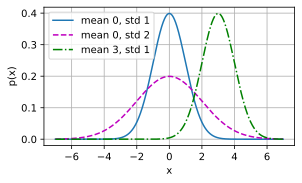

In [6]:
# Use NumPy again for visualization
x = np.arange(-7, 7, 0.01)

# Mean and standard deviation pairs
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])


平均値の変更は $x$ 軸に沿ったシフトに対応し、分散が増加すると分布が広がり、そのピークが低くなることに注意してください。

二乗損失による線形回帰を動機付ける 1 つの方法は、ノイズが次のように正規分布するノイズの多い測定から観測が発生すると仮定することです。

 $$y = \mathbf{w}^\top \mathbf{x} + b + \epsilon \text{ ここで } \epsilon \sim \mathcal{N}(0, \sigma^2).$$

したがって、与えられた $\mathbf{x}$ に対して特定の $y$ が表示される*可能性を*次のように書き出すことができます。

 $$P(y \mid \mathbf{x}) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (y - \mathbf{w}^\top \mathbf{x} - b)^2\right).$$

したがって、可能性は因数分解されます。*最尤の原理*によれば、パラメータ $\mathbf{w}$ と $b$ の最適な値は、データセット全体の*尤度*を最大化する値です。

 $$P(\mathbf y \mid \mathbf X) = \prod_{i=1}^{n} p(y^{(i)} \mid \mathbf{x}^{(i)}).$ $

すべてのペア $(\mathbf{x}^{(i)}, y^{(i)})$ は互いに独立して描画されたため、等価性が得られます。最尤の原理に従って選択された推定量は、*最尤推定量*と呼ばれます。多くの指数関数の積を最大化するのは難しそうに見えるかもしれませんが、代わりに尤度の対数を最大化することで、目的を変更せずに物事を大幅に単純化できます。歴史的な理由から、最適化は最大化ではなく最小化として表現されることがよくあります。したがって、何も変更せずに、*負の対数尤度**を最小化*できます。これは次のように表すことができます。

 $$-\log P(\mathbf y \mid \mathbf X) = \sum_{i=1}^n \frac{1}{2} \log(2 \pi \sigma^2) + \frac{1 }{2 \sigma^2} \left(y^{(i)} - \mathbf{w}^\top \mathbf{x}^{(i)} - b\right)^2.$$

 $\sigma$ が固定されていると仮定すると、最初の項は $\mathbf{w}$ や $b$ に依存しないので無視できます。 2 番目の項は、乗法定数 $\frac{1}{\sigma^2}$ を除いて、前に紹介した二乗誤差損失と同じです。幸いなことに、この解決策は $\sigma$ にも依存しません。したがって、平均二乗誤差を最小化することは、加法ガウス ノイズの仮定の下で線形モデルの最尤推定を行うことと同等であるということになります。

## ニューラル ネットワークとしての線形回帰

線形モデルは、この本で紹介する多くの複雑なニューラル ネットワークを表現するには十分に豊富ではありませんが、ニューラル ネットワークは、すべての特徴が入力ニューロンによって表され、すべてが接続されているニューラル ネットワークとして線形モデルを包含するのに十分な量を備えています。出力に直接出力します。

 :numref: `fig_single_neuron`線形回帰をニューラル ネットワークとして表します。この図では、各入力が出力にどのように接続されているかなどの接続パターンが強調表示されていますが、重みやバイアスによって取得される特定の値は強調表示されていません。 

![](http://d2l.ai/_images/singleneuron.svg) :label: `fig_single_neuron`

入力は $x_1、\ldots、x_d$ です。 $d$ を入力層の*入力数*または*特徴次元*と呼びます。ネットワークの出力は $o_1$ です。単一の数値を予測しようとしているだけなので、出力ニューロンは 1 つだけです。入力値はすべて*指定されている*ことに注意してください。*計算*ニューロンは 1 つだけです。要約すると、線形回帰は完全に接続された単一層のニューラル ネットワークとして考えることができます。今後の章では、はるかに多くの層を持つネットワークに遭遇します。

### 生物学

線形回帰は計算神経科学よりも古いものであるため、ニューラル ネットワークの観点から線形回帰を説明するのは時代錯誤に思えるかもしれません。それにもかかわらず、サイバネティストと神経生理学者のウォーレン・マカロックとウォルター・ピッツが人工ニューロンのモデルを開発し始めたとき、それらは自然な出発点でした。 :numref: `fig_Neuron`内の生物学的ニューロンの漫画的な絵を考えてみましょう。この絵は、*樹状突起*(入力端子)、*核*(CPU)、*軸索*(出力ワイヤー)、*軸索端子*(出力端子) で構成されており、他のニューロンへの接続を可能にします。*シナプス*。

![](http://d2l.ai/_images/neuron.svg) :ラベル: `fig_Neuron`

他のニューロン(または環境センサー)から届く情報$x_i$は樹状突起で受け取られます。特に、その情報は*シナプス重み*$w_i$ によって重み付けされ、積 $x_i w_i$ を介して入力の効果、たとえば活性化または抑制が決定されます。複数のソースから到着する重み付き入力は、重み付き合計 $y = \sum_i x_i w_i + b$ として核内に集約され、おそらく $\sigma(y)$ を介した非線形後処理の対象となります。次に、この情報は軸索を介して軸索末端に送信され、そこで目的地（たとえば、筋肉などのアクチュエーター）に到達するか、樹状突起を介して別のニューロンに供給されます。

確かに、そのような多くのユニットを適切な接続性と適切な学習アルゴリズムと組み合わせて、単一のニューロン単独で表​​現できるよりもはるかに興味深く複雑な動作を生成できるという高レベルのアイデアは、実際の生物学的神経システムの研究のおかげです。同時に、今日の深層学習の研究のほとんどは、より広範な情報源からインスピレーションを得ています。私たちは、飛行機は鳥から*インスピレーションを*得たかもしれないが、鳥類学は数世紀にわたって航空学の革新の主な推進力ではなかったと指摘した :citet: `Russell.Norvig.2016`を引用します。同様に、最近のディープラーニングのインスピレーションは、数学、言語学、心理学、統計学、コンピューターサイエンス、その他多くの分野から同等かそれ以上に得られています。

## まとめ

このセクションでは、トレーニング セットの二乗損失を最小限に抑えるように線形関数のパラメーターが選択される、従来の線形回帰を導入しました。また、この目標の選択は、いくつかの実際的な考慮事項と、線形性とガウス ノイズの仮定の下での最尤推定としての線形回帰の解釈の両方を通じて動機づけられました。計算上の考慮事項と統計との関係の両方を議論した後、入力が出力に直接接続される単純なニューラル ネットワークとしてそのような線形モデルをどのように表現できるかを示しました。私たちは間もなく線形モデルを完全に廃止しますが、パラメトリック形式、微分可能な目的、ミニバッチ確率的勾配降下による最適化、そして最終的にはこれまでに見たことのないデータの評価など、すべてのモデルに必要なコンポーネントのほとんどを導入するには十分です。

## 演習
1. \mathbb{R}$ にデータ $x_1, \ldots, x_n \ があるとします。私たちの目標は、$\sum_i (x_i - b)^2$ が最小化されるような定数 $b$ を見つけることです。<ol><li> $b$ の最適値の解析解を見つけます。
1. この問題とその解決策は正規分布とどのように関係するのでしょうか?
1. 損失を $\sum_i (x_i - b)^2$ から $\sum_i |x_i-b|$ に変更するとどうなるでしょうか? $b$ の最適解を見つけることができますか?
1. そうでない場合はどうなりますか?
1. どうすれば直せるでしょうか？ $\mathbf{X}$ のすべてのエントリに座標的に独立した少量のガウス ノイズを追加するとどうなるでしょうか?
1. この場合の計画行列 $\mathbf{X}^\top \mathbf{X}$ の期待値はいくらでしょうか?
1.  $\mathbf{X}^\top \mathbf{X}$ がフルランクでない場合、確率的勾配降下法では何が起こるでしょうか?
1. モデル $-\log P(\mathbf y \mid \mathbf X)$ でデータの負の対数尤度を書き出します。
1. クローズドフォームの解決策を見つけることができますか?
1. この問題を解決するためのミニバッチ確率的勾配降下法アルゴリズムを提案します。何が問題になる可能性がありますか (ヒント: パラメーターを更新し続けると、静止点の近くで何が起こりますか)。直せますか？
1. 加法ガウス ノイズの仮定が適切ではないことを示します。ヒント: マイナスの価格を設定できますか?変動についてはどうですか？
1. 価格の対数への回帰、つまり $y = \log \text{price}$ の方がはるかに優れているのはなぜでしょうか?
1. ペニーストック、つまり価格が非常に低い株を扱うとき、何を心配する必要がありますか?ヒント: あらゆる価格で取引できますか?なぜこれが安い株にとってより大きな問題なのでしょうか?
1. 詳細については、有名な Black-Scholes モデルのオプション価格を参照してください:cite: `Black.Scholes.1973` 。
1. ガウス加法ノイズ モデルにはどのような問題がありますか?ヒント: あなたが売っているのは油ではなくリンゴです。
1. [ポアソン分布は、](https://en.wikipedia.org/wiki/Poisson_distribution)カウントにわたる分布を捕捉します。 $p(k \mid \lambda) = \lambda^ke^{-\lambda}/k!$ で与えられます。ここで、$\lambda$ はレート関数、$k$ は表示されるイベントの数です。 $\lambda$ がカウント $k$ の期待値であることを証明します。
1. ポアソン分布に関連する損失関数を設計します。
1. 代わりに $\log \lambda$ を推定するための損失関数を設計します。



[ディスカッション](https://discuss.d2l.ai/t/258)
